In [116]:
import json 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [22]:
def readJson(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
    return data

In [74]:
class ARCDataset(Dataset):
    def __init__(self, json_files):
        self.json_files = json_files

    def __len__(self):
        return len(self.json_files)
    
    def __getitem__(self, index):
        file_name = self.json_files[index]
        arc_json_data = readJson(file_name)

        for s in arc_json_data['train']:
            s['input'] = np.array(s['input'], dtype=np.uint8)
            s['output'] = np.array(s['output'], dtype=np.uint8)

        for s in arc_json_data['test']:
            s['input'] = np.array(s['input'], dtype=np.uint8)
            s['output'] = np.array(s['output'], dtype=np.uint8)
        
        return arc_json_data


In [166]:
cmap = ListedColormap(['#000000', 
                       '#1f77b4', 
                       '#ff7f0e', 
                       '#2ca02c', 
                       '#d62728', 
                       '#9467bd', 
                       '#8c564b', 
                       '#e377c2', 
                       '#f0f0f0', 
                       '#bcbd22'])

def showTrainingImages(sample):
    trains = sample['train']
    tests = sample['test']

    rows = max(len(trains), len(tests))
    cols = 4
    _, axs = plt.subplots(rows, cols, figsize=(5, 5))

    axs[0, 0].set_title('Train Input')
    axs[0, 1].set_title('Train Output')
    axs[0, 2].set_title('Test Input')
    axs[0, 3].set_title('Test Output')

    for rows in axs:
        for ax in rows:
            ax.axis('off')
    
    for train, i in zip(trains, range(len(trains))):
        axs[i, 0].imshow(train['input'][0], cmap=cmap, vmin=0, vmax=9)
        axs[i, 1].imshow(train['output'][0], cmap=cmap, vmin=0, vmax=9)

    for test, i in zip(tests, range(len(tests))):
        axs[i, 2].imshow(test['input'][0], cmap=cmap, vmin=0, vmax=9)
        axs[i, 3].imshow(test['output'][0], cmap=cmap, vmin=0, vmax=9)

    plt.show()

In [167]:
training_dir = './data/evaluation'
train_file_names = [os.path.join(training_dir, file_name)
                    for file_name in os.listdir(training_dir)]

training_ds = ARCDataset(train_file_names)
dl = DataLoader(training_ds, batch_size=1, shuffle=True)

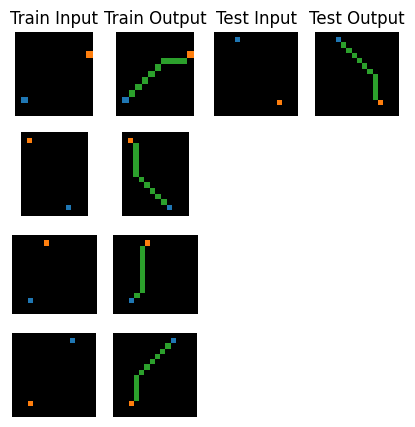

In [169]:
img = next(iter(dl))
showTrainingImages(img)